# 预训练语义分割模型预测-单张图像-Python API

推荐代码运行[云GPU环境](https://featurize.cn?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

同济子豪兄：https://space.bilibili.com/1900783

2022-1-11

## 进入 mmsegmentation 主目录

In [1]:
import os
os.chdir('mmsegmentation')

## 导入工具包

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import mmcv
from mmseg.apis import init_model, inference_model, show_result_pyplot
from mmseg.utils import register_all_modules
register_all_modules()

## Cityscapes数据集

Cityscapes语义分割数据集：https://www.cityscapes-dataset.com

[超详细！手把手带你轻松用 MMSegmentation 跑语义分割数据集](https://zhuanlan.zhihu.com/p/525422379)

19个类别
'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
'bicycle'

## 载入测试图像

In [4]:
from PIL import Image
img_path = 'demo/demo.png'
img_pil = Image.open(img_path)

In [5]:
img_pil.size

(1024, 512)

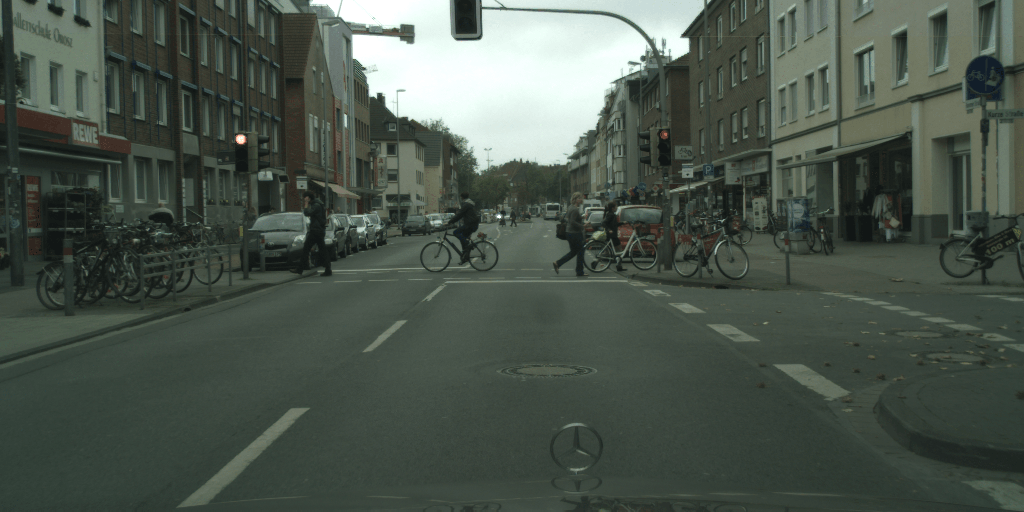

In [6]:
img_pil

### 载入模型

In [8]:
# 模型 config 配置文件
config_file = 'configs/mask2former/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024.py'
# config_file = 'configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py'

# 模型 checkpoint 权重文件
checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/mask2former/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024_20221202_141901-dc2c2ddd.pth'
# checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'


In [9]:
from mmseg.apis import init_model
model = init_model(config_file, checkpoint_file, device='cuda:0')

01/11 16:23:28 - mmengine - WARNING - The "model" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
01/11 16:23:30 - mmengine - WARNING - The "model" registry in mmdet did not set import location. Fallback to call `mmdet.utils.register_all_modules` instead.
01/11 16:23:30 - mmengine - WARNING - The "task util" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
01/11 16:23:30 - mmengine - WARNING - The "task util" registry in mmdet did not set import location. Fallback to call `mmdet.utils.register_all_modules` instead.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/mask2former/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024_20221202_141901-dc2c2ddd.pth


## 运行语义分割预测

In [36]:
from mmseg.apis import inference_model
from mmengine.model.utils import revert_sync_batchnorm
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)

In [ ]:
img_path = 'demo/demo.png'
result = inference_model(model, img_path)

In [14]:
result.keys()

['seg_logits', 'pred_sem_seg']

In [19]:
result.seg_logits.data.shape

torch.Size([19, 512, 1024])

In [21]:
# result.seg_logits.data

In [24]:
result.pred_sem_seg.data.shape

torch.Size([1, 512, 1024])

In [26]:
result.pred_sem_seg.data

tensor([[[5, 5, 5,  ..., 2, 2, 2],
         [5, 5, 5,  ..., 2, 2, 2],
         [5, 5, 5,  ..., 2, 2, 2],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')

## 可视化语义分割预测结果-方法一

opacity控制透明度，越小，越接近原图。

In [30]:
vis_result = show_result_pyplot(model, img_path, result)

/environment/miniconda3/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:170: UserWarning: `Visualizer` backend is not initialized because save_dir is None.
  warnings.warn('`Visualizer` backend is not initialized '


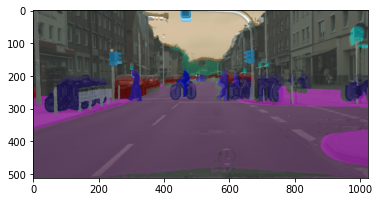

In [41]:
plt.imshow(mmcv.bgr2rgb(vis_result))
plt.show()

## 可视化语义分割预测结果-方法二

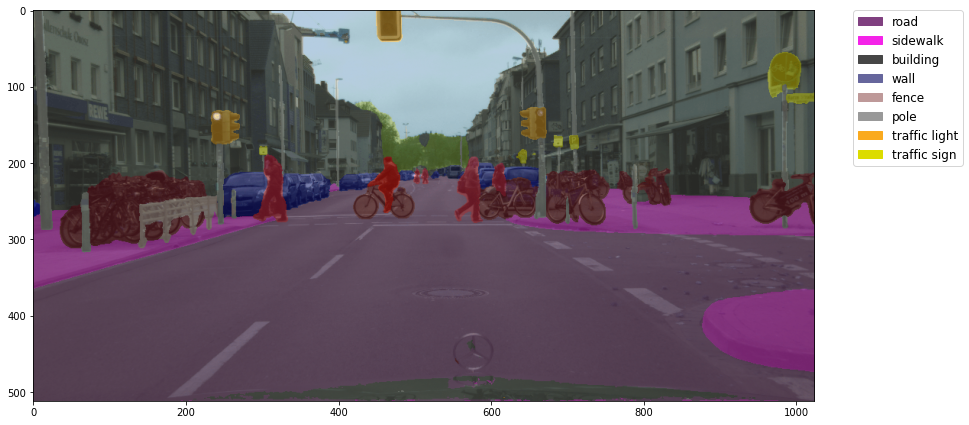

In [62]:
# 可视化分割图
from mmseg.datasets import CityscapesDataset
import numpy as np
import mmcv 

# 获取类别名和调色板
classes = CityscapesDataset.METAINFO['classes']
palette = CityscapesDataset.METAINFO['palette']

# 将分割图按调色板染色
seg_map = np.array(result.pred_sem_seg.data[0].cpu()).astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(14, 8))
im = plt.imshow(((np.array(seg_img.convert('RGB')))*0.4 + mmcv.imread('demo/demo.png')*0.6) / 255)

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(8)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()